In [2]:
library("variancePartition")
library(dplyr)
library(tools)
library("DESeq2")
library(sva)
library(RColorBrewer)
library(pheatmap)
library('stringr')
library(clusterProfiler)
library(org.Mm.eg.db)
library(AnnotationDbi)

In [3]:
setwd("~/Downloads/GSE133506_RAW/")
files = list.files()

In [3]:
files
# drop c('AdiposeOWT_1', 'AdiposeOKO_4')
# files = c('AdiposeOKO_1.txt','AdiposeOKO_2.txt','AdiposeOKO_3.txt','AdiposeOWT_2.txt','AdiposeOWT_3.txt','AdiposeOWT_4.txt')

[1] "ATAC_RNA_DE.csv"         "GSM3910499_NM1_WT_1.txt"
[3] "GSM3910500_NM1_WT_2.txt" "GSM3910501_NM1_WT_3.txt"
[5] "GSM3910502_NM1_KO_1.txt" "GSM3910503_NM1_KO_2.txt"
[7] "GSM3910504_NM1_KO_3.txt" "sva_mef_cleaned.csv"

In [4]:
files = files[grepl("txt",files)]
counts_table = read.csv(files[1], header = F, sep = "\t")
colnames(counts_table) = c("V1", file_path_sans_ext(files[1]))
for (i in 2:length(files)) {
  counts_sample <- read.csv(files[i], header = F, sep = "\t")
  counts_table <- merge(counts_table, counts_sample, by = "V1")
  colnames(counts_table)[i + 1] <- file_path_sans_ext(files[i])
}
rownames(counts_table) = counts_table$V1
counts_table = subset( counts_table, select = -V1 )
print(dim(counts_table))
counts_matrix = as.matrix(counts_table)
counts_matrix = counts_matrix[rowSums(counts_matrix) > 0, ]
print(dim(counts_matrix))
head(counts_table)


[1] 46603     6
[1] 25902     6


,GSM3910499_NM1_WT_1,GSM3910500_NM1_WT_2,GSM3910501_NM1_WT_3,GSM3910502_NM1_KO_1,GSM3910503_NM1_KO_2,GSM3910504_NM1_KO_3
,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000000001,940,1045,874,2911,2797,2005
ENSMUSG00000000003,0,0,0,0,0,0
ENSMUSG00000000028,247,307,264,484,246,367
ENSMUSG00000000031,31090,37449,46633,49412,36831,36696
ENSMUSG00000000037,6,2,7,19,16,14
ENSMUSG00000000049,3,6,1,3,4,4


In [5]:
counts_metadata = data.frame(colnames(counts_matrix),
                             NA, NA,
                             stringsAsFactors = FALSE)
colnames(counts_metadata) = c("sample", "genotype", "replicate")
# counts_metadata$age = 'O'
# counts_metadata$age[grepl("Y",counts_metadata$sample)] = 'Y'
# counts_metadata$genotype = str_replace(counts_metadata$sample, 'GSM3910', '')
# counts_metadata$genotype = str_replace(counts_metadata$genotype, 'AdiposeY', '')
counts_metadata$genotype = str_split(counts_metadata$sample, '_', simplify = T)[,3]
counts_metadata$replicate = as.numeric(str_split(counts_metadata$sample, '_', simplify = T)[,4])
counts_metadata

sample,genotype,replicate
<chr>,<chr>,<dbl>
GSM3910499_NM1_WT_1,WT,1
GSM3910500_NM1_WT_2,WT,2
GSM3910501_NM1_WT_3,WT,3
GSM3910502_NM1_KO_1,KO,1
GSM3910503_NM1_KO_2,KO,2
GSM3910504_NM1_KO_3,KO,3


In [6]:
gene_id = read.csv('/Volumes/GS4T/WORK/SAMIRA/ensmus_id.tsv', sep = '\t', row.names = 1, header=F)
colnames(gene_id) = 'symbol'
rownames(counts_matrix) = gene_id[rownames(counts_matrix),]

In [ ]:
# rm AdiposeOWT_1

In [7]:
dds = DESeqDataSetFromMatrix(countData = counts_matrix,
                              colData = counts_metadata,
                              design = ~ genotype + replicate ) %>% estimateSizeFactors() %>% estimateDispersions()
# counts_metadata

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“154 duplicate rownames were renamed by adding numbers”
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [8]:
dds <- DESeq(dds)
idx = rowMeans(counts(dds)) > 16
dat = counts(dds)[idx,]
mod = model.matrix(~  genotype + replicate, colData(dds))
mod0 = model.matrix(~ 1, colData(dds))
svseq = svaseq(dat, mod, mod0)


using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

In [9]:
ddssva = dds[idx,]
ddssva$SV1 = svseq$sv[,1]
# ddssva$SV2 = svseq$sv[,2]
# ddssva$SV3 = svseq$sv[,3]

design(ddssva) = ~ SV1 + genotype + replicate
ddssva = DESeq(ddssva)


using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [10]:
# res = results(dds, name="phenotype_WT_vs_KO")
res = lfcShrink(ddssva, coef="genotype_WT_vs_KO", type="apeglm")


using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [11]:
`%nin%` = Negate(`%in%`)
subr = res
# subr = subset(res, rownames(res) %nin% c('Gm8797') & padj<=.05)
# subr = subset(res, padj<=.05)

Warning message:
“ggrepel: 907 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


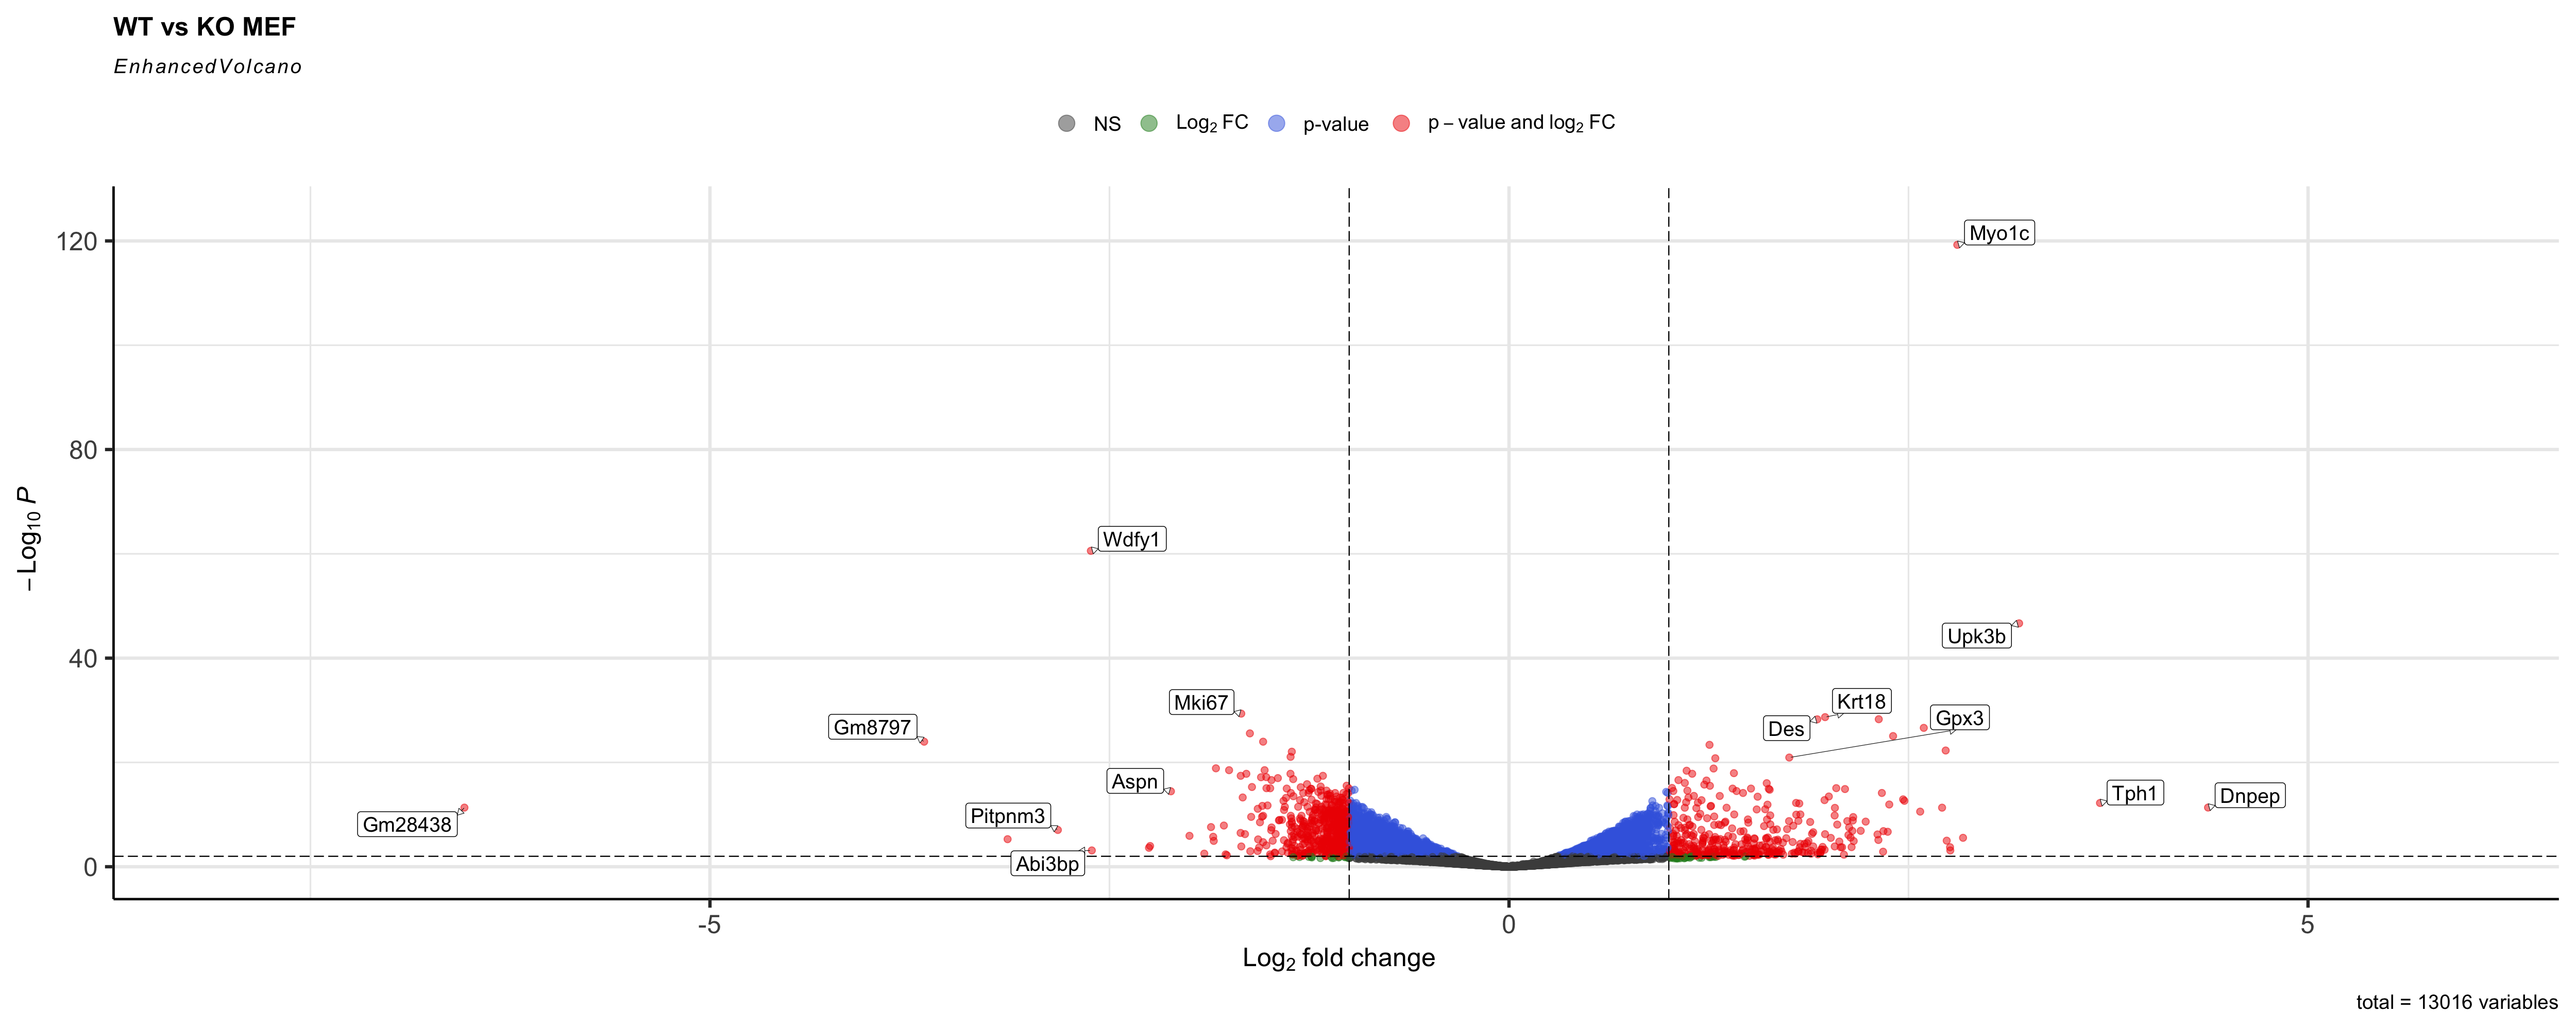

In [29]:
library(EnhancedVolcano)

# meanSdPlot(assay(dds))
# res
# if (!requireNamespace('BiocManager', quietly = TRUE))
#     install.packages('BiocManager')
# library('EnhancedVolcano')
options(repr.plot.width=25, repr.plot.height=10)

EnhancedVolcano(subr,
lab = rownames(subr),
x = 'log2FoldChange', boxedLabels = T,
                drawConnectors = TRUE,
    widthConnectors = 0.2,title= 'WT vs KO MEF',
y = 'padj',FCcutoff = 1, pCutoff = 10e-3)


In [27]:
# meanSdPlot(assay(vsd))


In [13]:
vsd = vst(ddssva, blind=FALSE)
sampleDists = dist(t(assay(vsd)))
sampleDistMatrix = as.matrix(sampleDists)
rownames(sampleDistMatrix) = vsd$sample
colnames(sampleDistMatrix) = vsd$sample

In [14]:
rownames(counts_metadata) = counts_metadata$sample
counts_metadata$replicate = as.character(counts_metadata$replicate)

In [15]:
tmp_meta = subset(vsd@colData, select = -sample)
tmp_meta = subset(tmp_meta, select = -replicate)

In [16]:
tmp_meta = data.frame(tmp_meta)
tmp_meta = subset(tmp_meta, select = -sizeFactor)

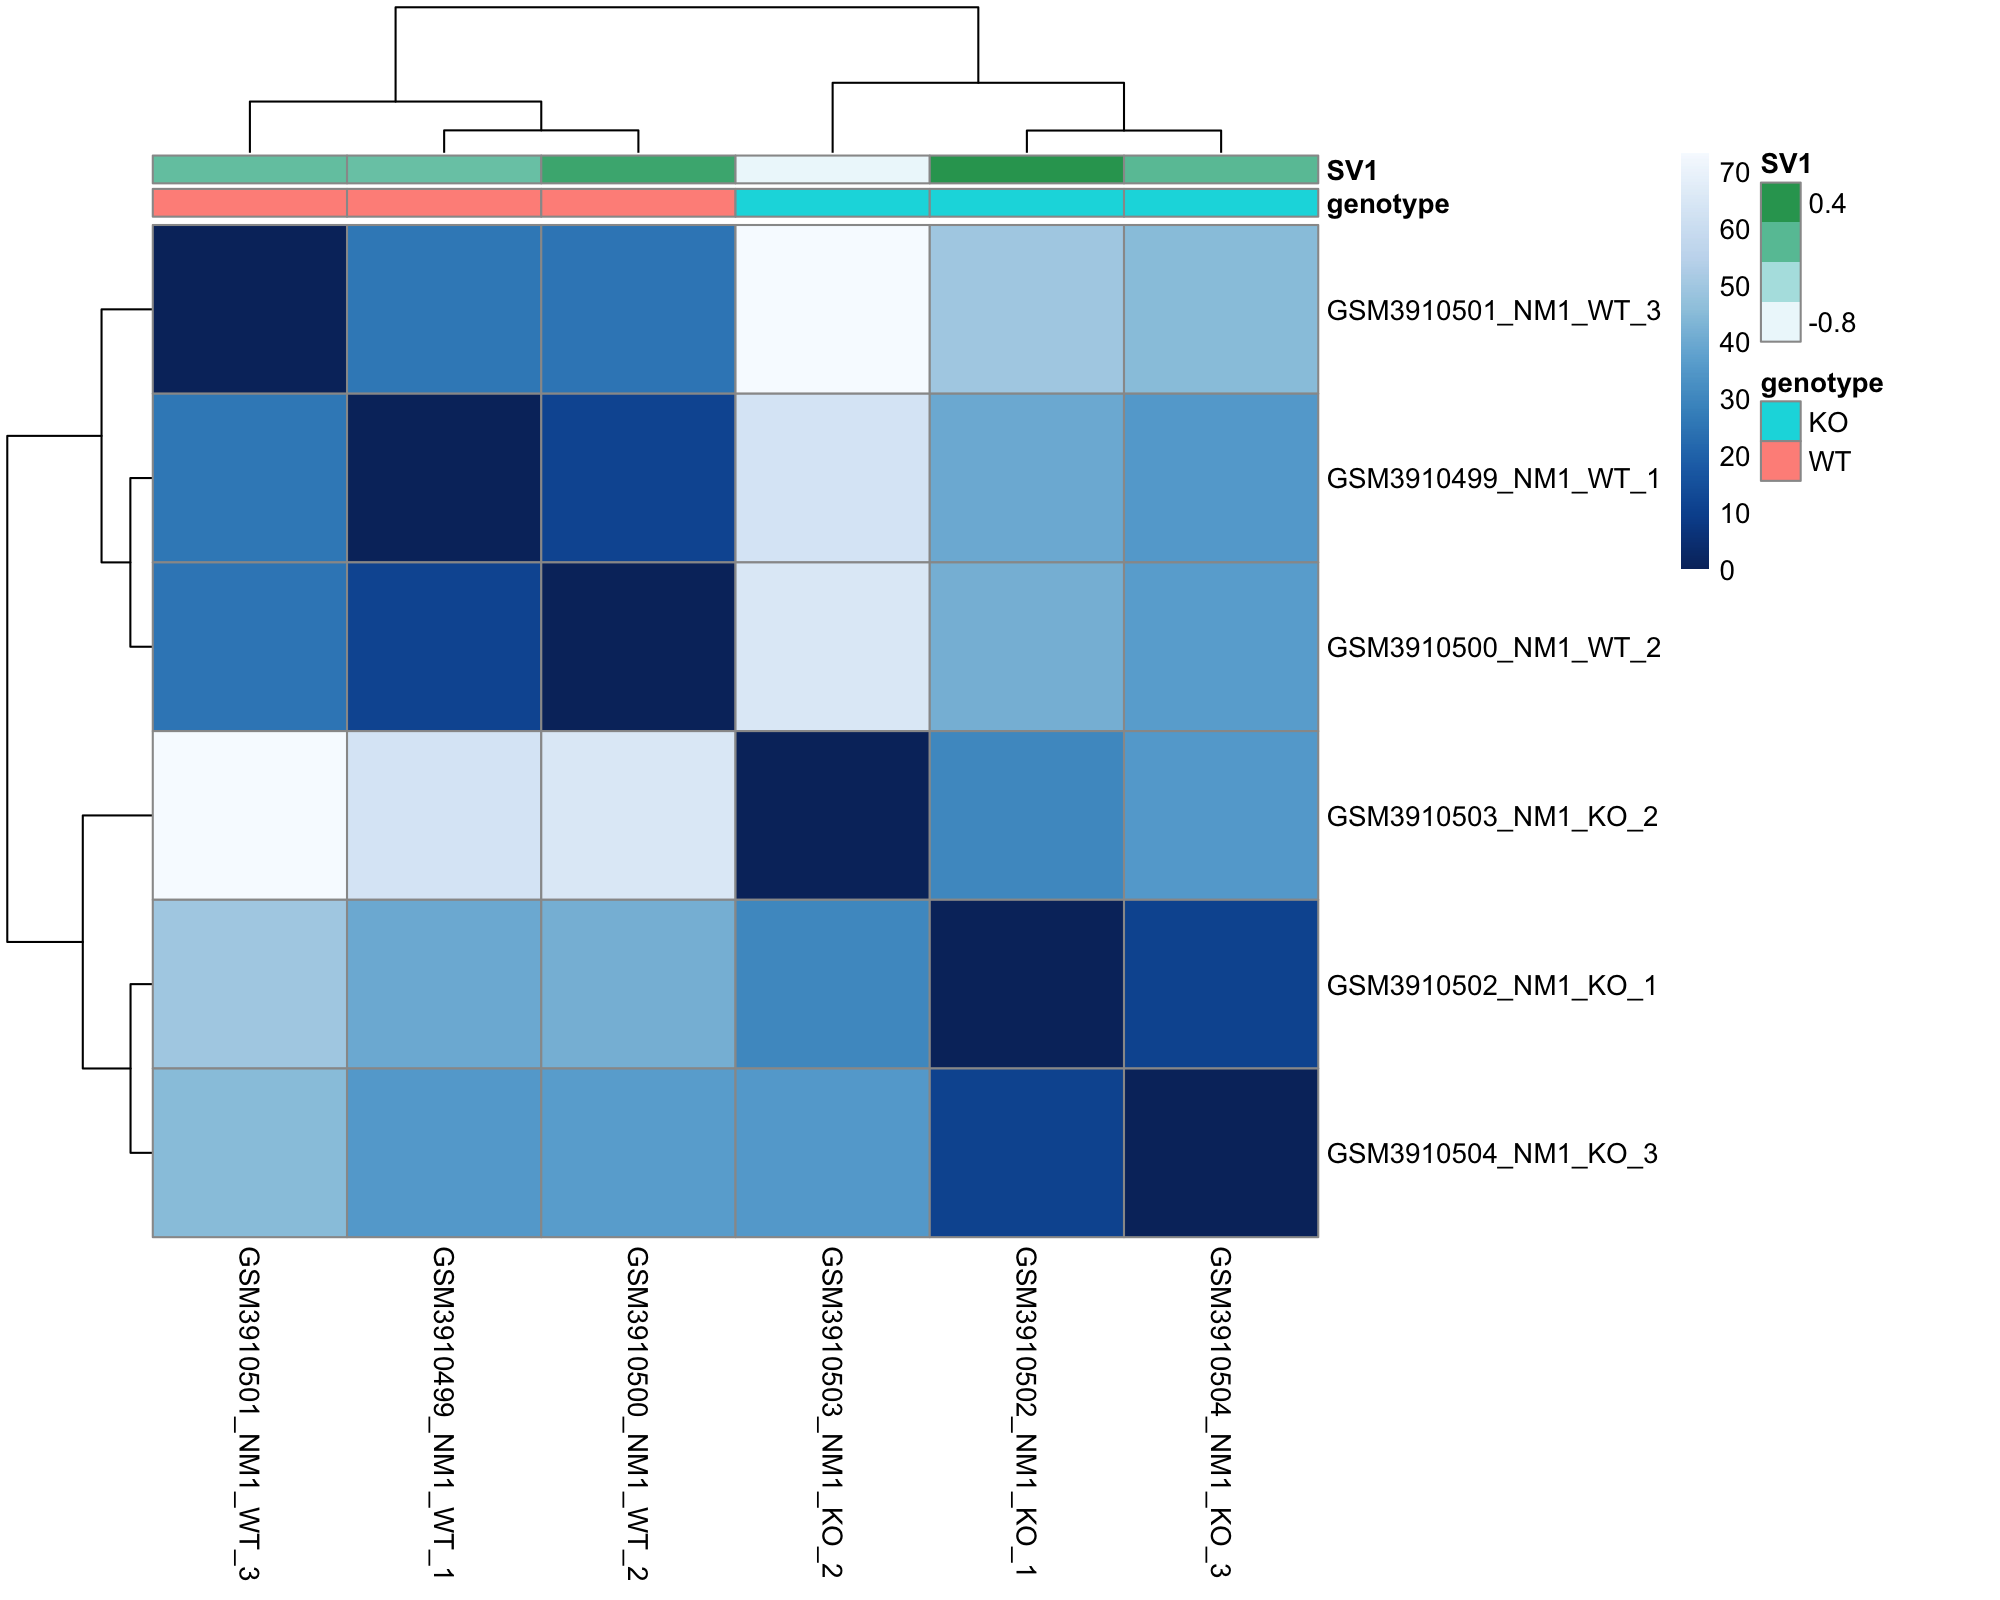

In [17]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 200)

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors, show_rownames=T, annotation_col=tmp_meta)

In [ ]:
# drop c('AdiposeOWT_1', 'AdiposeOKO_4')

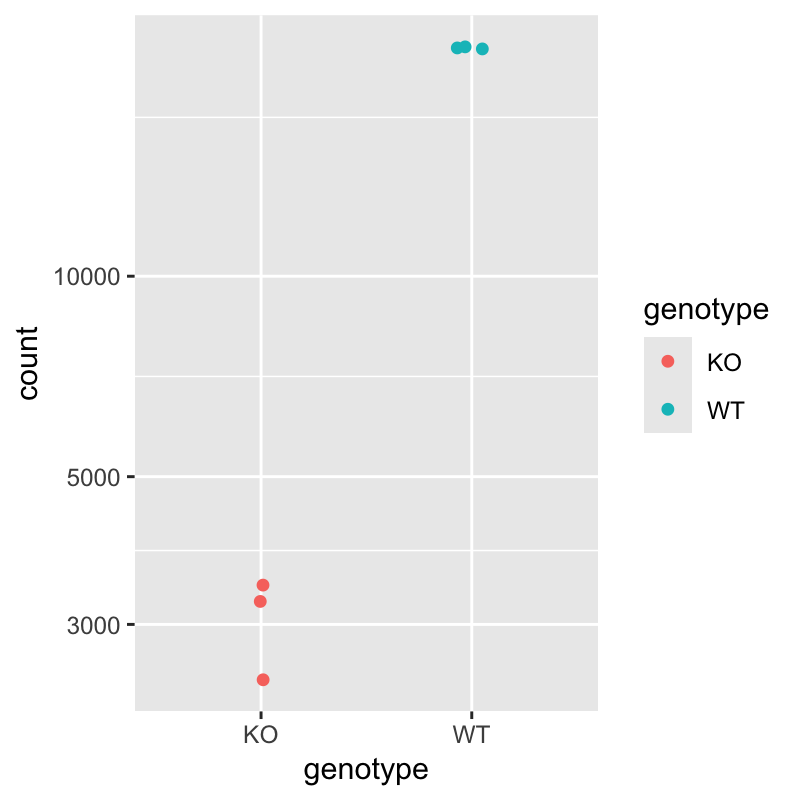

In [27]:
library(ggplot2)
d = plotCounts(dds, gene=c('Myo1c'), intgroup=c("genotype","replicate"), returnData=TRUE)
ggplot(d, aes(x=genotype, y=count, color=genotype)) + 
  geom_point(position=position_jitter(w=0.1,h=0)) + 
  scale_y_log10()

In [31]:
# d = plotCounts(dds, gene=c( 'Xist'), intgroup=c("phenotype","age"), returnData=TRUE)
# ggplot(d, aes(x=ge, y=count, color=age)) + 
#   geom_point(position=position_jitter(w=0.1,h=0)) + 
#   scale_y_log10()

In [80]:
# dds@colData$Xist = 'low'
# dds@colData[rownames(subset(d, count>1000)),'Xist'] = 'high'

In [82]:
# vsd@colData$Xist = 'low'
# vsd@colData[rownames(subset(d, count>1000)),'Xist'] = 'high'

using ntop=500 top features by variance



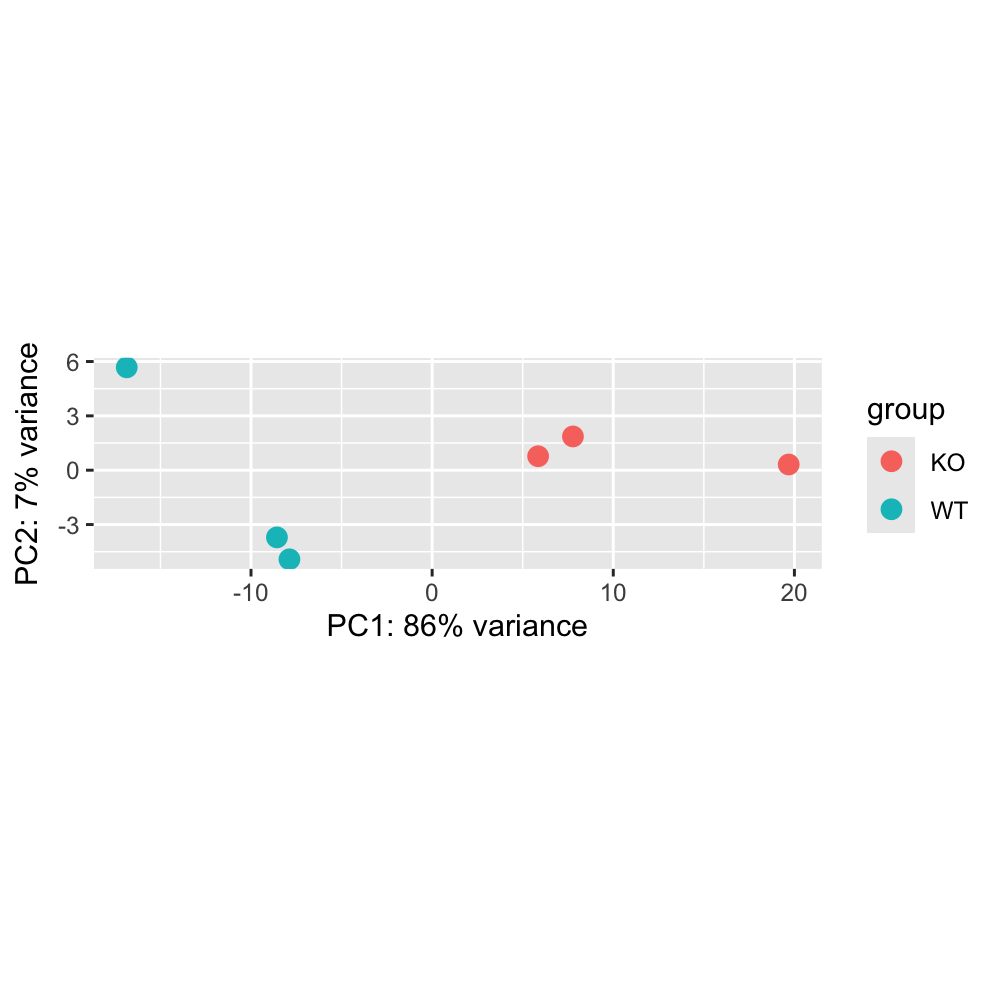

In [28]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
plotPCA(vsd, intgroup=c('genotype'))
# plotPCA(vsd, intgroup=c('phenotype','age'))

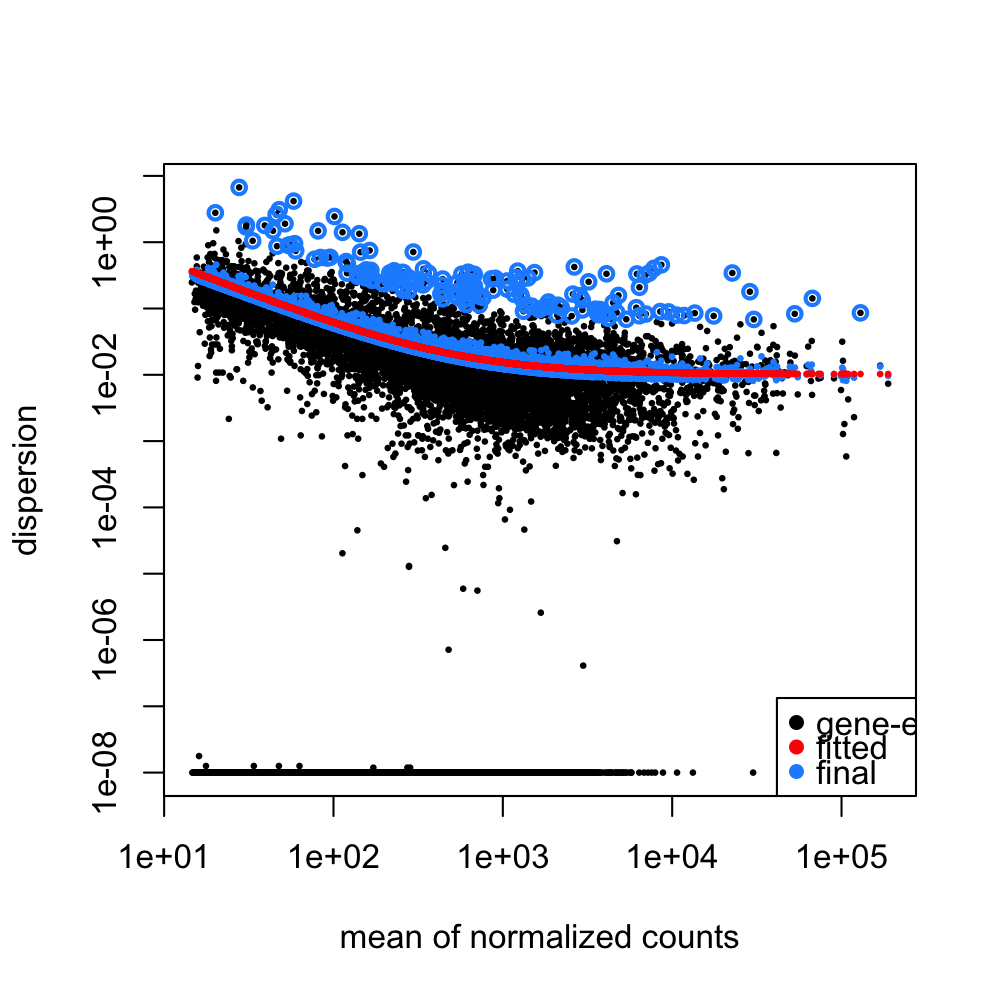

In [20]:
plotDispEsts(ddssva)

In [21]:
vsd = vst(ddssva, blind=FALSE)

my_form = ~ genotype  + replicate + SV1 
varPart = fitExtractVarPartModel(assay(vsd), my_form, colData(ddssva))



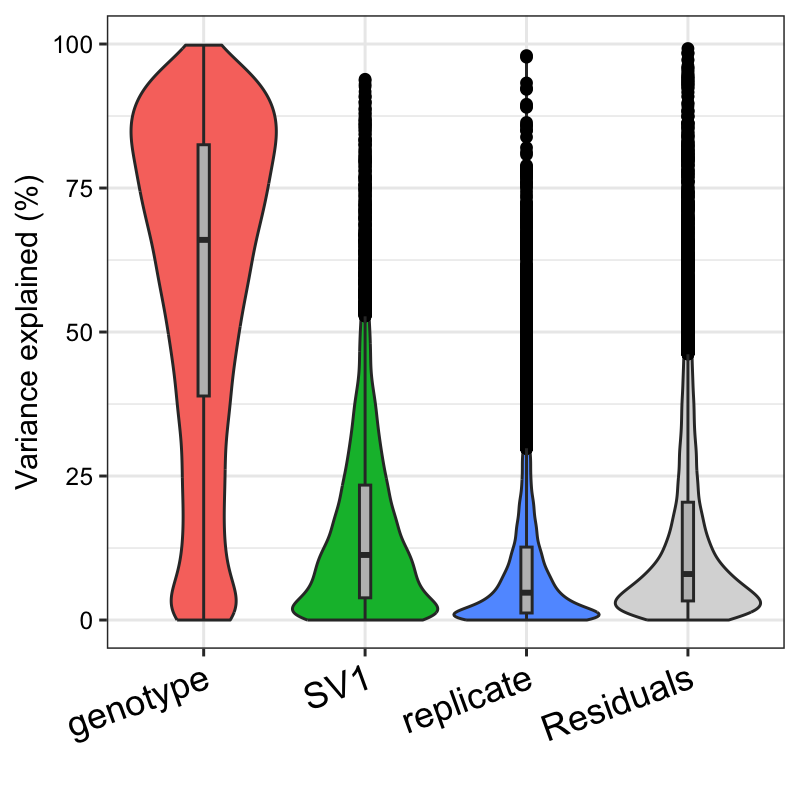

In [22]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 200)
plotVarPart(sortCols(varPart))

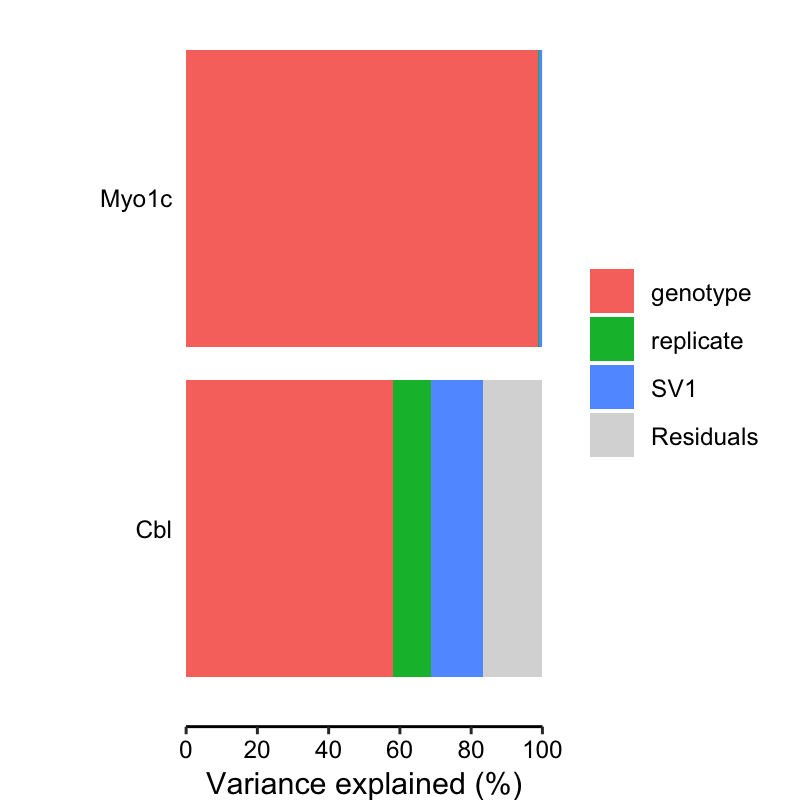

In [23]:
plotPercentBars(varPart[c('Myo1c','Cbl'),])

In [24]:
varPart[which(varPart$genotype>=.78),]

,genotype,replicate,SV1,Residuals
,<dbl>,<dbl>,<dbl>,<dbl>
Gnai3,0.8700829,1.151041e-02,1.026730e-01,0.015733665
Cav2,0.8742396,2.451603e-02,9.425987e-02,0.006984512
Klf6,0.8449275,5.156903e-05,3.589316e-02,0.119127796
Fer,0.8243388,3.593180e-02,1.249978e-01,0.014731562
Tfe3,0.7815015,1.047294e-02,1.891267e-01,0.018898868
Brat1,0.8472331,4.146375e-02,2.398412e-02,0.087319012
Sdhd,0.7903624,4.493127e-02,5.032001e-02,0.114386348
Gpr107,0.9687904,9.917709e-03,2.012857e-02,0.001163330
Itgb2,0.9146839,1.446605e-02,7.587799e-03,0.063262250


In [25]:
summary(varPart$genotype)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.3889  0.6600  0.5878  0.8251  0.9980 

In [62]:
# dat = counts(dds, normalized=TRUE)
# mod = model.matrix(~ replicate + phenotype + age, colData(dds))
# mod0 <- model.matrix(~ 1 , colData(dds))
# n.sv <- num.sv(dat, mod, method = "be")
# print(n.sv)
# svseq <- svaseq(dat, mod, mod0, n.sv=n.sv)
# head(svseq$sv)

In [ ]:
# Also chart the results section from the figure 
# potentially correlate with HiC
# 

In [24]:
# write.csv(res, 'sva_mef_cleaned.csv')
# res

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0140694,GO:0140694,non-membrane-bounded organelle assembly,180/4630,402/28891,1.112680e-42,7.148967e-39,3.502013e-39,Kat2b/Chmp1a/Ddx3x/Fmr1/Poldip2/Tubb5/Mybpc3/Hck/Tpr/Casq1/Tcap/Vps4b/Kif11/Rps5/Pten/Nkx2-5/Zfp207/Rrp7a/Ncor1/Trim37/Fbxo5/Hdac2/Cnot2/Csrp2/Mdm1/Cnot6/Drg1/Dbnl/Pum2/4933427D14Rik/Myh10/Krt19/Asb2/Eif5/Mterf3/Kif2a/Cenpk/Ldb3/Mapk8/Lcp1/Pibf1/Fitm1/Brix1/Sqle/Bop1/Prkdc/Rttn/Ndc80/Washc1/Cep192/Rps14/Ddb1/Sac3d1/Smc3/Cenpx/Chmp6/Plk4/Stag2/Cflar/Eif5b/Csrp1/Nek2/Gsn/Caprin1/Haus2/Tpx2/Eif6/Fxr1/Eif2a/Gpsm2/Sass6/Myoz2/Gtf2b/Tmod1/Chmp5/Stil/Mfn2/Wrap73/Mrpl20/Mapre3/Pdgfra/Cenpc1/Kntc1/Fscn1/Rpl6/Pan3/Ppp1r35/Csrp3/Rps3/Abraxas2/Bccip/Pqbp1/Cetn2/Myom2/Cnot7/Acta1/Ddx6/Kif23/Rpsa/Mzt1/Clasp2/Arhgef5/Stard9/Tubgcp5/Map9/Ccp110/Aspm/Ino80/Chmp7/Senp6/Six4/Cnot6l/Abraxas1/Mpv17l2/Abt1/Cep135/Cnot1/Stag1/Dlgap5/Haus6/Fau/Nop2/Rpf2/Prc1/Cdk5rap2/Synpo2l/Hnrnpu/Neurl2/Prrc2c/Rc3h1/Mis12/Rps19/Smc1a/Dicer1/Nop53/Pgm5/Lmod3/Cenph/Cenpe/Cep295/Mrps7/Cltc/Ythdf3/Lmod1/Nrap/Krt8/Actn2/Ep300/Jmjd6/Npm1/Mdn1/Tmod3/Cds2/Rpl11/Tnnt3/Mospd2/Cav3/Actg1/Rps15/Alms1/Cenpj/Tnnt1/mt-Rnr2/Akap13/Lsm14a/Rplp0/Myl9/Aup1/Cep152/Actc1/Csde1/Rnf213/Tia1/Bscl2/Klhl41/Capn3/Xirp1/Haus3/Rps6-ps4/Rps27,180
GO:0008380,GO:0008380,RNA splicing,184/4630,449/28891,3.666423e-37,1.177838e-33,5.769792e-34,Arvcf/Kat2b/Fmr1/Crnkl1/Srpk3/Celf2/Puf60/Cdk12/Taf6l/Akt2/Hnrnpa2b1/Celf1/Hnrnph1/Snrpb2/Myod1/Rbm25/Sugp1/Nol3/Hnrnpl/Hspa8/Wt1/Srsf1/Fxr2/Hnrnph3/Clk4/Taf15/Ddx5/Tsen54/Luc7l3/Pnn/Srsf5/Prpf4b/Snrnp48/Habp4/Ddx46/Hnrnpk/Ppwd1/Srek1ip1/Atxn7/Sap18/Zc3h13/Wbp4/Mbnl2/Eny2/Slc38a2/Zcrb1/Ppil2/Tra2b/Son/Paxbp1/Prmt5/Ivns1abp/Pcbp4/Hnrnpll/Snrpc/Thoc1/Iws1/Tcerg1/Prpf19/Alyref/Cwf19l2/Sf3b1/Clk1/Ncl/Prdx6/Cwc22/Snrpb/Rbm38/Raly/Rbm39/Aar2/Ctnnbl1/Fxr1/Supt20/Mbnl1/Ccnl1/Prpf38b/Larp7/Rnpc3/Mettl14/Ptbp2/Zranb2/Ptbp3/Psip1/Ppie/Srsf10/Sfpq/Ccnl2/Dhx15/Rest/Zfp326/Tfip11/Zcchc8/Rbm19/Rbm28/Tra2a/Luc7l2/Zfp638/Magohb/Fus/Rbmx2/Pqbp1/Aff2/Zrsr2/Rbm41/Usb1/Zpr1/Syncrip/Rbm5/Rbm6/Usp4/Srek1/Scaf11/Thoc5/Rsrc1/Gcfc2/Tsen34/Prpf39/Ythdc1/Rbmxl1/Rbm17/Rsrp1/Thoc2/Nsrp1/Cdc40/Bud31/Srrm2/Prpf18/Hnrnpu/Zc3h10/Virma/Snrpd2/Cdk13/Pik3r1/Tardbp/Cir1/Hnrnpf/Rbm7/Dhx9/Setx/Taf10/Thrap3/Lsm8/Gemin7/Hnrnph2/Hnrnpa1/Rbm12b1/Rbm15/Tada3/Lsm10/Lgals3/Rbm12b2/Ppp4r2/Prx/Thoc7/Fra10ac1/Mettl4/Gemin6/Jmjd6/Npm1/Pus7/Hnrnpa3/Hnrnpm/Akap17b/Prmt7/Sap18b/Prpf40a/Srpk2/Nup98/Fam172a/Htatsf1/Mfap1a/Clk2/Ahnak/Srsf3/Tia1/Sf3b5/U2af1l4/Esrp2/Rbm12/Rps13/Lsm5/Malat1/Snrpn,184
GO:0022613,GO:0022613,ribonucleoprotein complex biogenesis,179/4630,440/28891,1.093445e-35,2.341795e-32,1.147158e-32,Mcts1/C1d/Kat2b/Ddx3x/Nhp2/Mrpl10/Nom1/Crnkl1/Srpk3/Celf2/Ipo4/Puf60/Pih1d1/Rps11/Nob1/Utp20/Ddx56/Bud23/Celf1/Rsl1d1/Rps9/Rps5/Pten/Nol3/Tsr3/Eif3d/Rrp7a/Srsf1/Nop9/Ddx21/Xpo1/Pes1/Ddx52/Luc7l3/Gtpbp4/Hsp90aa1/Eif5/Nol8/Mterf3/Brix1/Bop1/Prkdc/Tarbp2/Denr/Prmt5/Rrp36/Bysl/Snrpc/Wdr46/Rbfa/Rps14/Prpf19/Rpp30/Eif3a/Tma16/Usp16/Sf3b1/Wdr75/Nop58/Eif5b/Ncl/Cdc73/Eif2d/Tfb2m/Nvl/Snrpb/Eif6/Aar2/Exosc9/Exosc8/Mbnl1/Nmd3/Eif2a/Ptbp2/Rpf1/1700009N14Rik/Psip1/Srsf10/Ago3/Gnl2/Mrpl20/Zcchc4/Sdad1/Ddx54/Rpl6/Pop7/Malsu1/Luc7l2/Bms1/Pop4/Mphosph10/Eri2/Cul4b/Dkc1/Eri1/Mphosph6/Urb2/Atr/Rpsa/Rbm5/Usp4/Dis3/Scaf11/Wdr3/Eri3/Rbm34/Atm/Gcfc2/Eif2s3x/Mpv17l2/Utp6/Prpf39/Wdr18/Ythdc1/Serbp1/Abt1/Nop14/Rsrp1/Rps16/Rpl10a/Mrm3/Fau/Nop2/Tsr1/Rpf2/Prpf18/Dnttip2/Gtpbp10/Ckap5/Tbl3/Snrpd2/Rps19/Wdr43/Dicer1/Rrp9/Nop53/Wdr55/Dhx9/Wdr74/Setx/Gemin7/Esf1/Mrps7/Isg20l2/Rps27rt/Rps19bp1/Zfp622/Ddx10/Grwd1/Utp18/Cpsf6/Gemin6/Npm3/Npm1/Ddx49/Mdn1/Abce1/Rpl11/Prmt7/Pop5/Exosc5/Srpk2/Rpl7a/Nol7/Rpl27/Krr1/Rps15/mt-Rnr2/Rplp0/Lyar/Eif2s3y/Ptges3/Rpl13a/Eif2s2/Utp14b/Pin4/Rps6-ps4/Rps27/Rps13,179
GO:0006397,GO:0006397,mRNA processing,188/4630,496/28891,1.392010e-32,2.235916e-29,1.095292e-29,Arvcf/Tbrg4/Fmr1/Crnkl1/Srpk3/Celf2/Puf60/Cdk12/Slbp/Hnrnpa2b1/Celf1/Aplp1/Hnrnph1/Snrpb2/Myod1/Rnmt/Rbm25/Sugp1

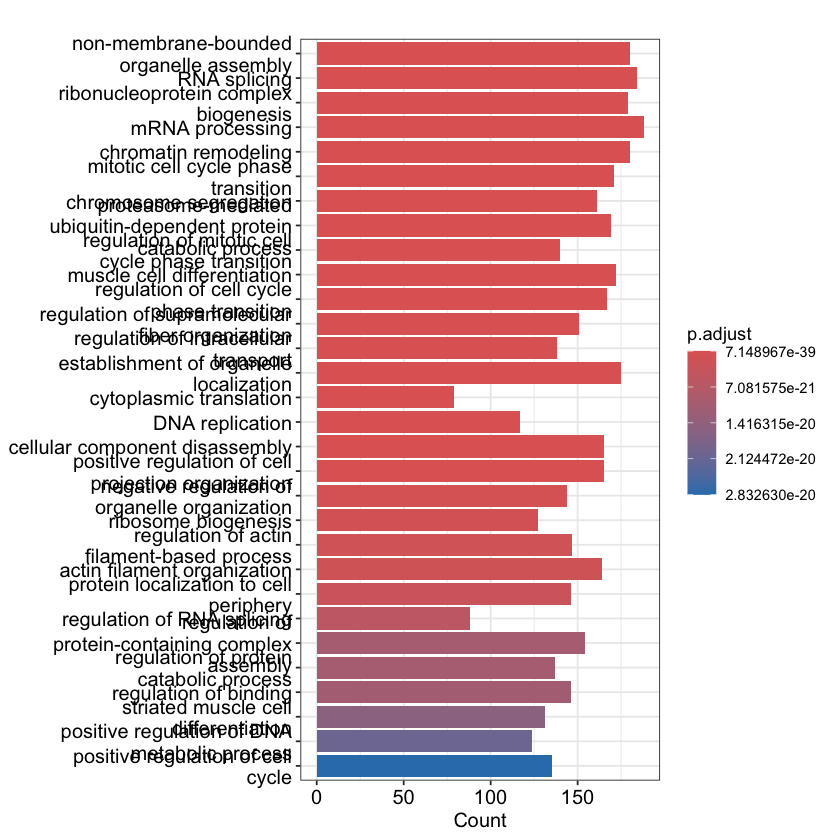

In [28]:
res = read.csv('/Users/gas361/Downloads/GSE133506_RAW/sva_mef_cleaned.csv')
genes_to_test = subset(res,(log2FoldChange >= 0.5 | log2FoldChange <= -0.5 )& padj <= 0.05 & baseMean >= 16)[,1]
GO_results = enrichGO(gene = genes_to_test, OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
head(as.data.frame(GO_results))
plot(barplot(GO_results, showCategory = 30))


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0050900,GO:0050900,leukocyte migration,41/526,398/28891,3.581502e-19,1.668622e-15,1.056732e-15,Itgb2/Ccl3/Ccl8/Mmp9/Lyst/Lgmn/Cxcl14/Nckap1l/Retnlg/Cd200r1/Vegfa/Trem2/Rock1/Myo1f/Ptprj/Adam8/Podxl/Abl2/Vcam1/Pf4/Flt1/Ptpro/Cd9/Lyve1/F7/Vegfc/Slit2/Mmp2/Smpd3/Thy1/Cadm1/Cd300a/Serpine1/C3ar1/Rin3/S1pr1/Wnk1/Cd24a/Lgals3/Lep/Fcgr3,41
GO:0007162,GO:0007162,negative regulation of cell adhesion,36/526,315/28891,1.932848e-18,4.502571e-15,2.851460e-15,Col1a1/Cd44/Fbln1/Notch4/Sema4d/Nckap1l/Vegfa/Myo1f/Lpxn/Adam8/Podxl/Abl2/Myoc/Il1rn/Ccm2l/Tnc/Gpnmb/Cd9/Mmp2/Jak3/Cd300a/H2-Aa/Serpine1/Gimap3/Pla2g2d/Cdkn2a/Wnk1/Cd24a/Mmp12/Fzd4/Lgals3/Vtcn1/Prkg1/Lilrb4a/Plxnc1/Ass1,36
GO:0030198,GO:0030198,extracellular matrix organization,34/526,322/28891,1.998624e-16,2.248661e-13,1.424068e-13,Col1a1/Fbln1/Wt1/Vtn/Mmp9/Myh11/Lama2/Lcp1/Col14a1/Mmp19/Col5a2/Col3a1/Dpt/Abl2/Eng/Pdgfra/Col1a2/Mmp2/Smpd3/Agt/Tie1/Atp7a/Loxl2/Adamtsl2/Ctss/Mfap4/Mmp3/Adamts12/Mmp12/Lgals3/Spock2/Hmcn1/Tcf15/Col8a1,34
GO:0045229,GO:0045229,external encapsulating structure organization,34/526,323/28891,2.196570e-16,2.248661e-13,1.424068e-13,Col1a1/Fbln1/Wt1/Vtn/Mmp9/Myh11/Lama2/Lcp1/Col14a1/Mmp19/Col5a2/Col3a1/Dpt/Abl2/Eng/Pdgfra/Col1a2/Mmp2/Smpd3/Agt/Tie1/Atp7a/Loxl2/Adamtsl2/Ctss/Mfap4/Mmp3/Adamts12/Mmp12/Lgals3/Spock2/Hmcn1/Tcf15/Col8a1,34
GO:0043062,GO:0043062,extracellular structure organization,34/526,324/28891,2.413244e-16,2.248661e-13,1.424068e-13,Col1a1/Fbln1/Wt1/Vtn/Mmp9/Myh11/Lama2/Lcp1/Col14a1/Mmp19/Col5a2/Col3a1/Dpt/Abl2/Eng/Pdgfra/Col1a2/Mmp2/Smpd3/Agt/Tie1/Atp7a/Loxl2/Adamtsl2/Ctss/Mfap4/Mmp3/Adamts12/Mmp12/Lgals3/Spock2/Hmcn1/Tcf15/Col8a1,34
GO:0045765,GO:0045765,regulation of angiogenesis,33/526,307/28891,3.293949e-16,2.557751e-13,1.619814e-13,Itgb2/Serpinf1/Aqp1/Sash1/Cybb/Notch4/Mmp9/Ptgis/Pik3cg/Rapgef3/Cela1/Thbs2/Vegfa/Rock1/Eng/Nos3/Flt1/Itgax/Vegfc/Cdh5/Bmper/Agt/Tie1/Serpine1/C3ar1/Isl1/Gpr4/Wnk1/Lgals3/Adam12/Lep/Hipk2/Kdr,33


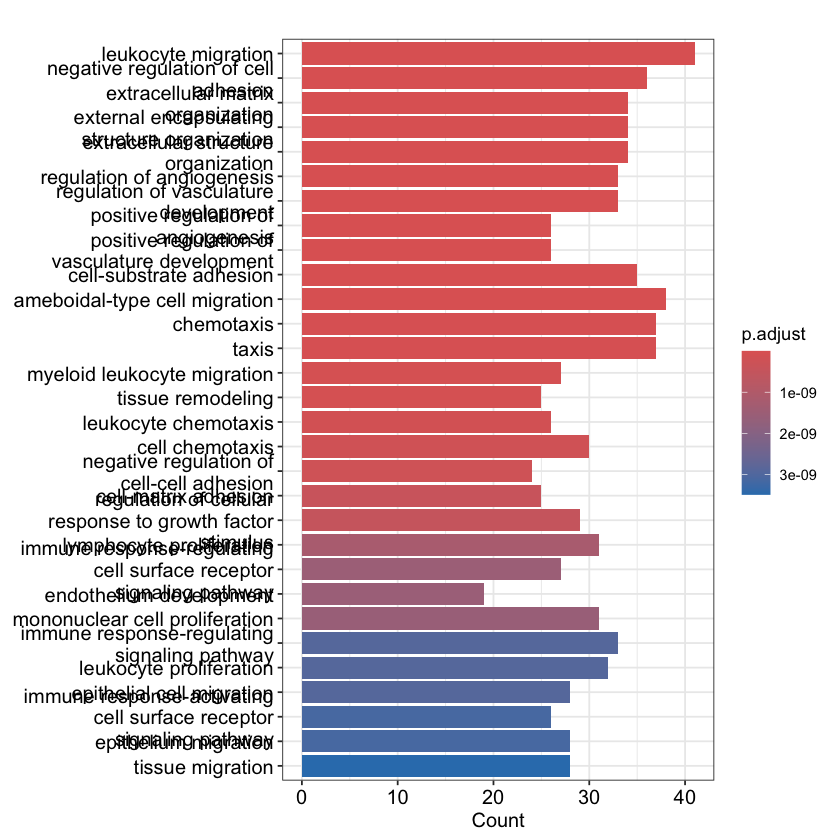

In [29]:
# /Users/gas361/Downloads/GSE133506_RAW/sva_mef_cleaned.csv
res = read.csv('/Users/gas361/Downloads/adipose/sva_adipose_cleaned.csv')
genes_to_test = subset(res,(log2FoldChange >= 0.5 | log2FoldChange <= -0.5 )& padj <= 0.05 & baseMean >= 16)[,1]
GO_results = enrichGO(gene = genes_to_test, OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
head(as.data.frame(GO_results))
plot(barplot(GO_results, showCategory = 30))

# subset(res,(log2FoldChange > 0.5 | log2FoldChange <= -0.5 )& padj < 0.05 & baseMean > 50)[,1]

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0050900,GO:0050900,leukocyte migration,23/243,398/28891,5.171784e-13,1.878909e-09,1.356641e-09,Ptprj/Vcam1/Lgmn/Nckap1l/Rock1/Abl2/Wnk1/Lyst/Rin3/Myo1f/Smpd3/Trem2/Lgals3/Cxcl14/Serpine1/Slit2/C3ar1/Fcgr3/Adam8/Itgb2/Cd9/Cd300a/Vegfa,23
GO:0002685,GO:0002685,regulation of leukocyte migration,18/243,249/28891,4.751342e-12,3.979254e-09,2.873166e-09,Ptprj/Lgmn/Nckap1l/Abl2/Wnk1/Rin3/Myo1f/Smpd3/Trem2/Lgals3/Cxcl14/Serpine1/Slit2/C3ar1/Adam8/Cd9/Cd300a/Vegfa,18
GO:0030198,GO:0030198,extracellular matrix organization,20/243,322/28891,4.892332e-12,3.979254e-09,2.873166e-09,Pdgfra/Lcp1/Myh11/Wt1/Col8a1/Mfap4/Eng/Ctss/Hmcn1/Adamts12/Abl2/Adamtsl2/Mmp3/Col5a2/Smpd3/Atp7a/Lamc1/Lgals3/Col3a1/Lama2,20
GO:0045229,GO:0045229,external encapsulating structure organization,20/243,323/28891,5.176728e-12,3.979254e-09,2.873166e-09,Pdgfra/Lcp1/Myh11/Wt1/Col8a1/Mfap4/Eng/Ctss/Hmcn1/Adamts12/Abl2/Adamtsl2/Mmp3/Col5a2/Smpd3/Atp7a/Lamc1/Lgals3/Col3a1/Lama2,20
GO:0043062,GO:0043062,extracellular structure organization,20/243,324/28891,5.476540e-12,3.979254e-09,2.873166e-09,Pdgfra/Lcp1/Myh11/Wt1/Col8a1/Mfap4/Eng/Ctss/Hmcn1/Adamts12/Abl2/Adamtsl2/Mmp3/Col5a2/Smpd3/Atp7a/Lamc1/Lgals3/Col3a1/Lama2,20
GO:0097529,GO:0097529,myeloid leukocyte migration,17/243,253/28891,5.993741e-11,3.629210e-08,2.620422e-08,Ptprj/Lgmn/Nckap1l/Lyst/Rin3/Myo1f/Trem2/Lgals3/Serpine1/Slit2/C3ar1/Fcgr3/Adam8/Itgb2/Cd9/Cd300a/Vegfa,17


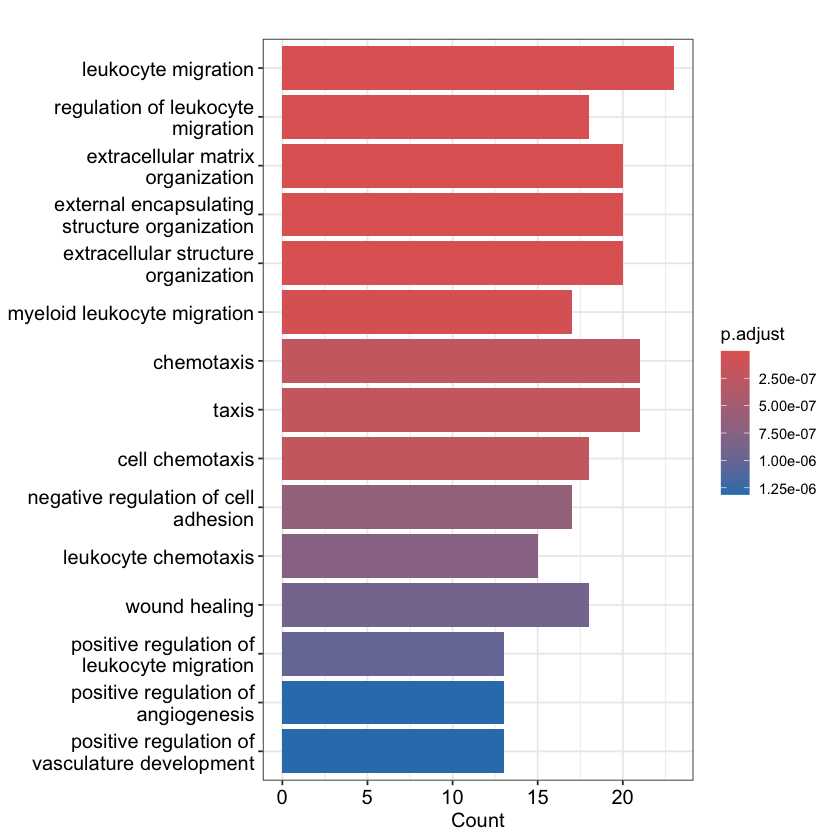

In [33]:
# /Users/gas361/Downloads/GSE133506_RAW/sva_mef_cleaned.csv
res = read.csv('/Users/gas361/Desktop/shared_MEF_ADP.txt', header=F)
# res
GO_results = enrichGO(gene = res$V1, OrgDb = "org.Mm.eg.db", keyType = "SYMBOL", ont = "BP")
head(as.data.frame(GO_results))
plot(barplot(GO_results, showCategory = 15))



In [10]:
normalized_counts = counts(ddssva, normalized=TRUE)
write.csv(t(counts(ddssva, normalized=T)),'~/Desktop/SAMIRA/subnet/MEF_SVA_bulk.csv')

In [17]:
l1p = log1p(normalized_counts)

In [20]:
write.csv(t(l1p),'~/Desktop/SAMIRA/subnet_out/MEF_bulk.csv')